# Compare different ML models

- with first order derivatives
- across resolutions

In [1]:
import xarray as xr
import numpy as np 

import jax
from typing import Any, Callable, Sequence
from jax import lax, random, numpy as jnp
#from flax.core import freeze, unfreeze
from flax import linen as nn
from flax.training import train_state 
from flax.training import checkpoints

import optax
import xbatcher
import fsspec

#import hvplot.xarray

import matplotlib.pyplot as plt
from datatree import DataTree
from datatree import open_datatree

import xgcm

import sys

sys.path.append('../modules/')
import helper_func as hf
import ml_helper_func as ml_hf

In [2]:
import os 
M2LINES_BUCKET ='gs://leap-persistent/dhruvbalwada/m2lines_transfer'

In [3]:
# Open all the datasets
Lkey = ['50', '100', '200', '400']

ds = {}
for L in Lkey:
    
    ds_temp = xr.open_zarr(f'{M2LINES_BUCKET}/ML_data/ds_ML_'+L+'km_3D')
    
    ds[L] = ds_temp
ds_tree = DataTree.from_dict(ds)

# Open the mask files
ds_mask_tree = open_datatree(f'{M2LINES_BUCKET}/ML_data/ds_ML_masks', engine='zarr')

In [4]:
output_channels = ['Sfnx','Sfny']                                      
input_channels_single = ['U_x', 'U_y', 
                         'V_x', 'V_y',
                         'Sx', 'Sy'] 
input_channels_all = ['U_x', 'U_y', 
                      'V_x', 'V_y', 
                      'Sx', 'Sy', 'Lfilt']

In [5]:
# Setup the datatree with all the data
facs = {}

ds_tree_centered = {}
for L in Lkey:
    
    # Select dataset
    ds = ds_tree[L].ds
    grid = xgcm.Grid(ds, periodic='X')
    
    # Center the variables
    ds_centered = hf.center_data(ds)
    ds_centered['T_z'] = (ds_centered['T_z'].where(ds_centered['T_z']>=5e-5, 5e-5)) #.isel(time=0, XC=0).plot(vmin=-6e-3)

    # Add variables that are actually used in the model.
    ds_centered['Sx'] = -ds_centered['T_x']/ds_centered['T_z']
    ds_centered['Sy'] = -ds_centered['T_y']/ds_centered['T_z']

    ds_centered['Sfnx'] =  - ds_centered['uT']/ds_centered['T_z']
    ds_centered['Sfny'] =  - ds_centered['vT']/ds_centered['T_z']

    ds_centered['Lfilt'] = (float(L) + 0*ds_centered.T)
#     # Compute the VGM 
    dx = ds_centered.dxC[0,0].values
    fac = 13/6 * dx *dx 

    #     # Save the factors
    #     facs[L] = fac

    #     # VGM Model 
    ds_centered['Sfnx_vgm'] = -fac*(ds_centered.U_x*ds_centered.T_x + ds_centered.U_y*ds_centered.T_y)/ds_centered['T_z']
    ds_centered['Sfny_vgm'] = -fac*(ds_centered.V_x*ds_centered.T_x + ds_centered.V_y*ds_centered.T_y)/ds_centered['T_z']

    #     # GM model
    ds_centered['Sfnx_gm'] = 0.3*1e4*ds_centered.T_x/ds_centered['T_z']
    ds_centered['Sfny_gm'] = 0.3*1e4*ds_centered.T_y/ds_centered['T_z']

    # Only consider variables that will be used in ML
    ds_ML_vars = xr.merge([ds_centered[output_channels],
                           ds_centered[input_channels_all], 
                           ds_centered[['Sfnx_vgm', 'Sfny_vgm', 'Sfnx_gm', 'Sfny_gm']] ])
    
    ds_tree_centered[L] = ds_ML_vars
    
ds_tree_centered = DataTree.from_dict(ds_tree_centered)

In [6]:
# Open standardization constants file (divide by std) 

ds_std_tree = {}
for L in Lkey:
    ds_std_tree[L] = xr.open_zarr('./STD_'+L+'_km.nc')
    
ds_std_tree['all'] = xr.open_zarr('./STD_all.nc')
ds_std_tree = DataTree.from_dict(ds_std_tree)

In [8]:
# Define the state of the model

model, params = ml_hf.initialize_model([24, 24, 2], len(input_channels_single) )

learning_rate = .01
tx = optax.sgd(learning_rate=learning_rate)
state = train_state.TrainState.create(
            apply_fn=model.apply, params=params, tx=tx)


# If needed to work with all res
#model_all, params_all = ml_hf.initialize_model([24, 24, 2], len(input_channels_all) )
model_all, params_all = ml_hf.initialize_model([32, 32, 2], len(input_channels_single) )

learning_rate = .01
tx_all = optax.sgd(learning_rate=learning_rate)
state_all = train_state.TrainState.create(
            apply_fn=model_all.apply, params=params_all, tx=tx_all)

In [9]:
# Load the trained models in.

restored_states = {}

ds_pred_tree = {}
for L in Lkey: 
    
    print(L)
    # load model
    CKPT_DIR = './ckpts_'+ L 
    restored_states[L] = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)
    
restored_states['all'] = checkpoints.restore_checkpoint(ckpt_dir='./ckpts_single_all_res_medium/', target=state_all)

50
100
200
400


In [10]:
# Do inference for all datasets using all models.

Lkey_copy = Lkey.copy()
Lkey_copy.append('all')

ds_pred_tree_mix = {}

for L in Lkey: # Which data
    for L2 in Lkey_copy: # which model
    
        print(L, L2)
        ds_mask = ds_mask_tree[L].ds.maskC
        ds = ds_tree_centered[L].to_dataset().where(ds_mask>0.99999)

        # put data properly 
        ds_std = ds_std_tree[L2].to_dataset()

        ds_test = ds.isel(time=slice(-10, -1))

        ds_test_normalized = ds_test/ds_std

        restored_state = restored_states[L2]

        if L2 != 'all':
            y_pred = restored_state.apply_fn(restored_state.params, 
                                             ds_test_normalized[input_channels_single].to_array().transpose(...,'variable'))
        else:
            y_pred = restored_state.apply_fn(restored_state.params, 
                                             ds_test_normalized[input_channels_all].to_array().transpose(...,'variable'))
                                             
            
        
        dims = ds_test[output_channels].to_array().transpose(...,'variable').dims
        coords = ds_test[output_channels].to_array().transpose(...,'variable').coords

        ds_pred = xr.DataArray(y_pred, dims=dims, coords=coords).to_dataset(dim='variable')

        # Scale back
        ds_pred_unnormalized = xr.Dataset()

        ds_pred_unnormalized['Sfnx_pred'] = ds_pred['Sfnx'] * ds_std['Sfnx']
        ds_pred_unnormalized['Sfny_pred'] = ds_pred['Sfny'] * ds_std['Sfny']

        ds_pred_unnormalized['Sfnx_true'] = ds_test['Sfnx'] 
        ds_pred_unnormalized['Sfny_true'] = ds_test['Sfny'] 
    
        ds_pred_unnormalized['Sfnx_vgm'] = ds_test['Sfnx_vgm'] 
        ds_pred_unnormalized['Sfny_vgm'] = ds_test['Sfny_vgm']
        
        ds_pred_unnormalized['Sfnx_gm'] = ds_test['Sfnx_gm'] 
        ds_pred_unnormalized['Sfny_gm'] = ds_test['Sfny_gm']

        ds_pred_tree_mix[L+'-'+L2] = ds_pred_unnormalized
    
ds_pred_tree_mix = DataTree.from_dict(ds_pred_tree_mix)

50 50
50 100
50 200
50 400
50 all
100 50
100 100
100 200
100 400
100 all
200 50
200 100
200 200
200 400
200 all
400 50
400 100
400 200
400 400
400 all


In [11]:
ds_pred_tree_mix.load();

In [12]:
ds_pred = ds_pred_tree_mix['200-all'].to_dataset()

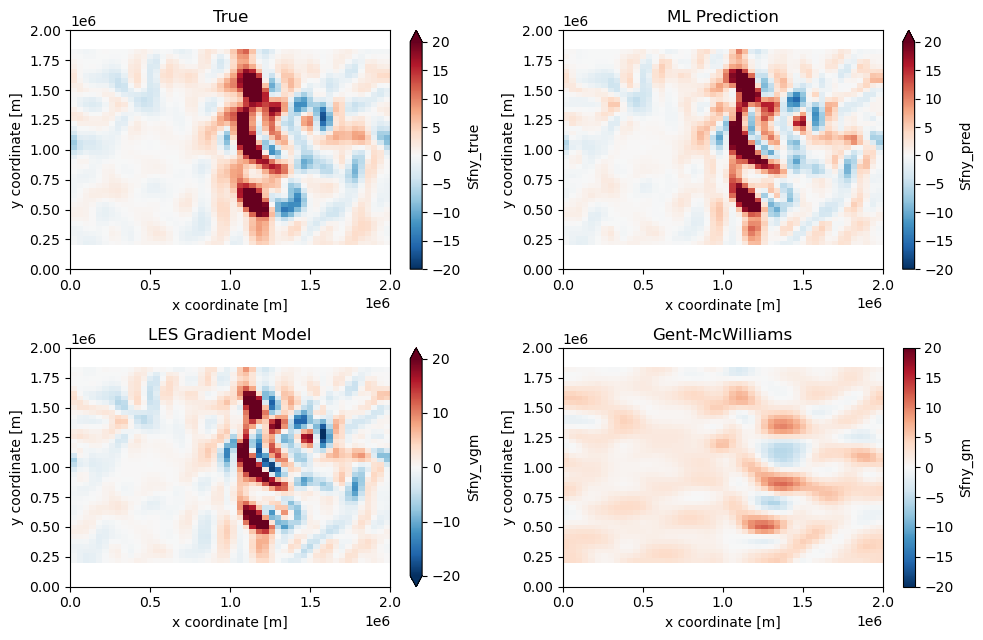

In [13]:
plt.figure(figsize=(10, 6.5))
zlev=15
vlevs = 20
plt.subplot(221)
ds_pred.Sfny_true.isel(time=0, Z=zlev).plot(vmin=-vlevs, vmax=vlevs, cmap='RdBu_r')
plt.title('True')

plt.subplot(222)
ds_pred.Sfny_pred.isel(time=0, Z=zlev).plot(vmin=-vlevs)
plt.title('ML Prediction')

plt.subplot(223)
ds_pred.Sfny_vgm.isel(time=0, Z=zlev).plot(vmin=-vlevs)
plt.title('LES Gradient Model')

plt.subplot(224)
ds_pred.Sfny_gm.isel(time=0, Z=zlev).plot(vmin=-vlevs)
plt.title('Gent-McWilliams')

plt.tight_layout()
plt.savefig('Comparison.png')

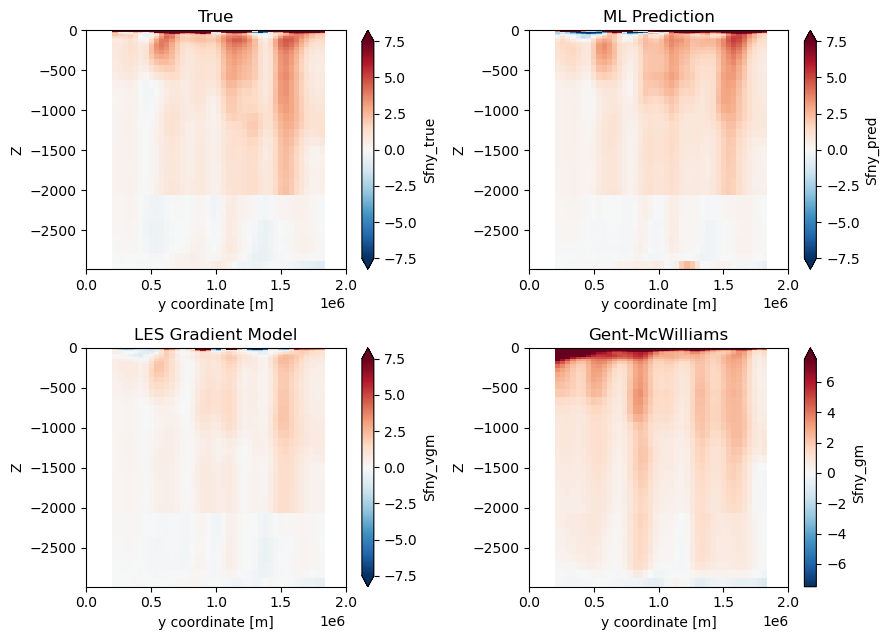

In [14]:
plt.figure(figsize=(9, 6.5))
zlev=5
vlevs = 7.5
plt.subplot(221)
ds_pred.Sfny_true.isel(time=0).mean('XC').plot(vmin=-vlevs, vmax=vlevs, cmap='RdBu_r')
plt.title('True')
plt.ylabel('Z')

plt.subplot(222)
ds_pred.Sfny_pred.isel(time=0).mean('XC').plot(vmin=-vlevs)
plt.title('ML Prediction')
plt.ylabel('Z')

plt.subplot(223)
ds_pred.Sfny_vgm.isel(time=0).mean('XC').plot(vmin=-vlevs)
plt.title('LES Gradient Model')
plt.ylabel('Z')

plt.subplot(224)
ds_pred.Sfny_gm.isel(time=0).mean('XC').plot(vmin=-vlevs)
plt.title('Gent-McWilliams')
plt.ylabel('Z')

plt.tight_layout()
#plt.savefig('Comparison_mean.png')

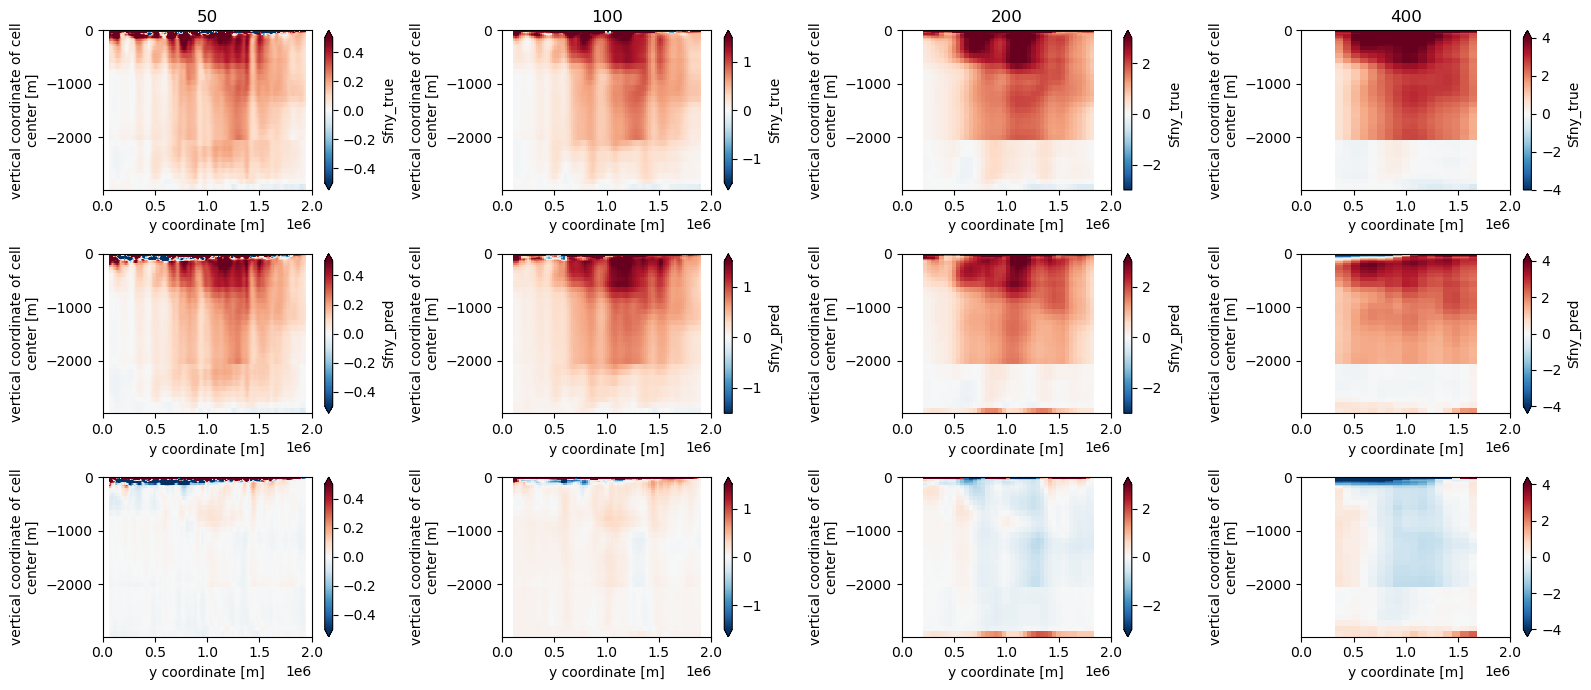

In [15]:
plt.figure(figsize=(16, 7))

#vlevs = [0.01, 0.005, 0.0025, 0.0012] 

vlevs = [.5, 1.5, 3., 4.]

for i,L in enumerate(Lkey): 
    plt.subplot(3,4,1+i)
    ds_pred_tree_mix[L+'-'+L]['Sfny_true'].mean(['time', 'XC']).plot(vmin=-vlevs[i], vmax=vlevs[i], cmap='RdBu_r')
    plt.title(L)
    
    plt.subplot(3,4,1+i + 4)
    ds_pred_tree_mix[L+'-'+L]['Sfny_pred'].mean(['time', 'XC']).plot(vmin=-vlevs[i], vmax=vlevs[i], cmap='RdBu_r')
    
    plt.subplot(3,4,1+i + 8)
    (ds_pred_tree_mix[L+'-'+L]['Sfny_pred']-ds_pred_tree_mix[L+'-'+L]['Sfny_true']).mean(['time', 'XC']).plot(vmin=-vlevs[i], vmax=vlevs[i], cmap='RdBu_r')
    
    
plt.tight_layout()

In [16]:
def R2_Z(ds, var='Sfny'):
    
    da_pred = ds[var+'_pred'].sel(YC=slice(400e3, 1600e3))
    da_truth = ds[var+'_true'].sel(YC=slice(400e3, 1600e3))
    
    RSS = ((da_pred  - da_truth)**2).mean(['time','YC','XC'])
    TSS = (da_truth**2).mean(['time','YC','XC'])
    R2_Z = 1 - RSS/TSS
    
    return R2_Z

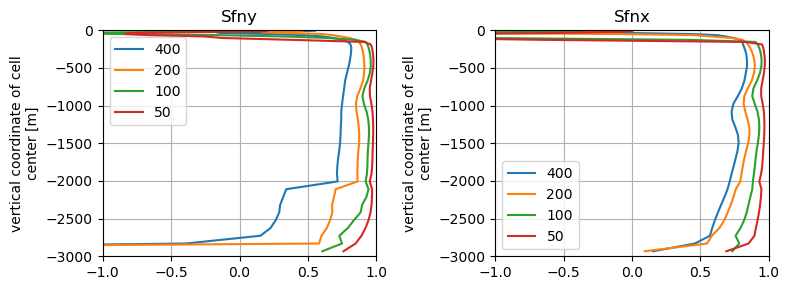

In [17]:
plt.figure(figsize = (8 , 3) )

plt.subplot(121)
R2_Z(ds_pred_tree_mix['400-400']).plot(y='Z', label='400')
R2_Z(ds_pred_tree_mix['200-200']).plot(y='Z', label='200')
R2_Z(ds_pred_tree_mix['100-100']).plot(y='Z', label='100')
R2_Z(ds_pred_tree_mix['50-50']).plot(y='Z', label='50')

plt.xlim([-1, 1])
plt.ylim([-3000, 0])
plt.grid()
plt.legend()
plt.title('Sfny')


plt.subplot(122)
R2_Z(ds_pred_tree_mix['400-400'], 'Sfnx').plot(y='Z', label='400')
R2_Z(ds_pred_tree_mix['200-200'], 'Sfnx').plot(y='Z', label='200')
R2_Z(ds_pred_tree_mix['100-100'], 'Sfnx').plot(y='Z', label='100')
R2_Z(ds_pred_tree_mix['50-50'], 'Sfnx').plot(y='Z', label='50')

plt.xlim([-1, 1])
plt.ylim([-3000, 0])
plt.grid()
plt.legend()
plt.title('Sfnx')

plt.tight_layout()

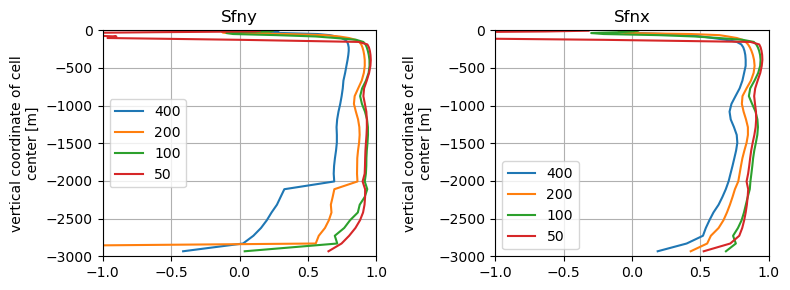

In [18]:

plt.figure(figsize = (8 , 3) )

plt.subplot(121)
R2_Z(ds_pred_tree_mix['400-all']).plot(y='Z', label='400')
R2_Z(ds_pred_tree_mix['200-all']).plot(y='Z', label='200')
R2_Z(ds_pred_tree_mix['100-all']).plot(y='Z', label='100')
R2_Z(ds_pred_tree_mix['50-all']).plot(y='Z', label='50')

plt.xlim([-1, 1])
plt.ylim([-3000, 0])
plt.grid()
plt.legend()
plt.title('Sfny')


plt.subplot(122)
R2_Z(ds_pred_tree_mix['400-all'], 'Sfnx').plot(y='Z', label='400')
R2_Z(ds_pred_tree_mix['200-all'], 'Sfnx').plot(y='Z', label='200')
R2_Z(ds_pred_tree_mix['100-all'], 'Sfnx').plot(y='Z', label='100')
R2_Z(ds_pred_tree_mix['50-all'], 'Sfnx').plot(y='Z', label='50')

plt.xlim([-1, 1])
plt.ylim([-3000, 0])
plt.grid()
plt.legend()
plt.title('Sfnx')

plt.tight_layout()

In [19]:
def R2_score(true, pred, dims=['XC', 'YC', 'time','Z']):
    RSS = ((true  - pred)**2).mean(dims)
    TSS = ((true)**2).mean(dims)
    R2 = 1 - RSS/TSS
    return R2 

In [20]:
def corr(true, pred, dims=['XC', 'YC', 'time','Z']):
    RSS = ((true - true.mean(dims))* (pred - pred.mean(dims))).mean(dims)
    TSS1 = ((true - true.mean(dims))**2).mean(dims)
    TSS2 = ((pred - pred.mean(dims))**2).mean(dims)
   
    corr =  RSS/(TSS1**0.5 * TSS2**0.5)
    return corr

In [21]:
R2_all_y = np.zeros((4,))
corr_all_y = np.zeros((4,))

R2_all_x = np.zeros((4,))
corr_all_x = np.zeros((4,))

Lscale = np.zeros((4,))
for i, L in enumerate(Lkey):
    ds = ds_pred_tree_mix[L+'-'+L]

    true = ds['Sfny_true'].isel(time=slice(-30, -1)).sel(YC=slice(400e3, 1600e3), Z=slice(-200, -2000))
    pred = ds['Sfny_pred'].isel(time=slice(-30, -1)).sel(YC=slice(400e3, 1600e3), Z=slice(-200, -2000))

    R2_all_y[i] =  R2_score(true, pred).values
    corr_all_y[i] = corr(true, pred).values
    
    true = ds['Sfnx_true'].isel(time=slice(-30, -1)).sel(YC=slice(400e3, 1600e3), Z=slice(-200, -2000))
    pred = ds['Sfnx_pred'].isel(time=slice(-30, -1)).sel(YC=slice(400e3, 1600e3), Z=slice(-200, -2000))

    R2_all_x[i] =  R2_score(true, pred).values
    corr_all_x[i] = corr(true, pred).values
    
    Lscale[i] = int(L)


In [23]:
R2_y_ML = np.zeros((4,))
corr_y_ML = np.zeros((4,))

R2_y_VGM = np.zeros((4,))
corr_y_VGM = np.zeros((4,))

R2_y_GM = np.zeros((4,))
corr_y_GM = np.zeros((4,))

R2_x_ML = np.zeros((4,))
corr_x_ML = np.zeros((4,))

Lscale = np.zeros((4,))
for i, L in enumerate(Lkey):
    ds = ds_pred_tree_mix[L+'-all']
  
    true = ds['Sfny_true'].isel(time=slice(-30, -1)).sel(YC=slice(400e3, 1600e3), Z=slice(-200, -2000))
    pred = ds['Sfny_pred'].isel(time=slice(-30, -1)).sel(YC=slice(400e3, 1600e3), Z=slice(-200, -2000))

    R2_y_ML[i] =  R2_score(true, pred).values
    corr_y_ML[i] =  corr(true, pred).values
    
    true = ds['Sfnx_true'].isel(time=slice(-30, -1)).sel(YC=slice(400e3, 1600e3), Z=slice(-200, -2000))
    pred = ds['Sfnx_pred'].isel(time=slice(-30, -1)).sel(YC=slice(400e3, 1600e3), Z=slice(-200, -2000))

    R2_x_ML[i] =  R2_score(true, pred).values
    corr_x_ML[i] =  corr(true, pred).values
    
    true = ds['Sfny_true'].isel(time=slice(-30, -1)).sel(YC=slice(400e3, 1600e3), Z=slice(-200, -2000))
    pred = ds['Sfny_vgm'].isel(time=slice(-30, -1)).sel(YC=slice(400e3, 1600e3), Z=slice(-200, -2000))

    R2_y_VGM[i] =  R2_score(true, pred).values
    corr_y_VGM[i] =  corr(true, pred).values
    
    true = ds['Sfny_true'].isel(time=slice(-30, -1)).sel(YC=slice(400e3, 1600e3), Z=slice(-200, -2000))
    pred = ds['Sfny_gm'].isel(time=slice(-30, -1)).sel(YC=slice(400e3, 1600e3), Z=slice(-200, -2000))

    R2_y_GM[i] =  R2_score(true, pred).values
    corr_y_GM[i] =  corr(true, pred).values
    
    
    Lscale[i] = int(L)

In [24]:
print(R2_all_x)
print(R2_all_x_all)

print(R2_all_y)
print(R2_all_y_all)

[0.96128656 0.92805857 0.87145762 0.81097199]


NameError: name 'R2_all_x_all' is not defined

In [55]:
print(corr_all_x)
print(corr_all_x_all)

print(corr_all_y)
print(corr_all_y_all)

[0.98050535 0.96331537 0.93290037 0.89715981]
[0.9769693  0.96280282 0.93325511 0.89780646]
[0.98539126 0.97176319 0.94287539 0.87064904]
[0.98235148 0.96977249 0.94422792 0.87702737]


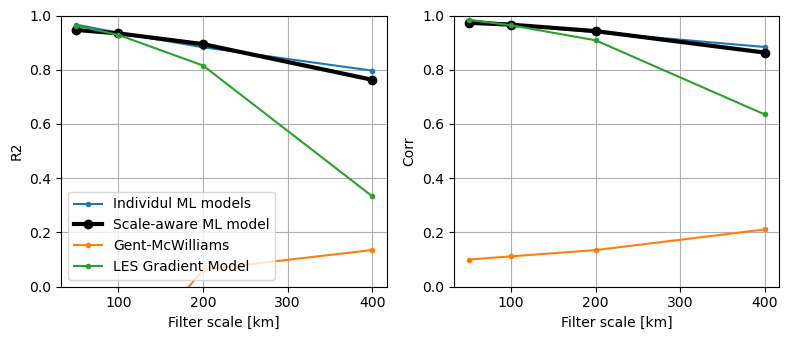

In [25]:
plt.figure(figsize= (8, 3.5))
plt.subplot(121)
plt.plot(Lscale, 0.5*(R2_all_y+R2_all_x),'.-', label='Individul ML models')
#plt.plot(Lscale, 0.5*(R2_all_y_all+R2_all_x_all),'.-', label='One model for all res')
plt.plot(Lscale, (R2_y_ML),'o-', label='Scale-aware ML model', linewidth=3., color='k')
plt.plot(Lscale, (R2_y_GM),'.-', label='Gent-McWilliams')
plt.plot(Lscale, (R2_y_VGM),'.-', label='LES Gradient Model')

plt.xlabel('Filter scale [km]')
plt.ylabel('R2')
plt.ylim([0., 1.])
plt.legend(loc='lower left')
#plt.title('First order models')
plt.grid()

plt.subplot(122)
plt.plot(Lscale, 0.5*(corr_all_x+corr_all_y),'.-', label='Trained on individual res')
#plt.plot(Lscale, 0.5*(corr_all_x_all+corr_all_y_all),'.-', label='One model for all res')
plt.plot(Lscale, (corr_y_ML),'o-', label='All res', linewidth=3., color='k')
plt.plot(Lscale, (corr_y_GM),'.-', label='GM')
plt.plot(Lscale, (corr_y_VGM),'.-', label='VGM')
plt.xlabel('Filter scale [km]')
plt.ylabel('Corr')
plt.ylim([0., 1.])
#plt.legend()
#plt.title('First order models')
plt.grid()

plt.tight_layout()

plt.savefig('comparison_models.png', dpi=300)

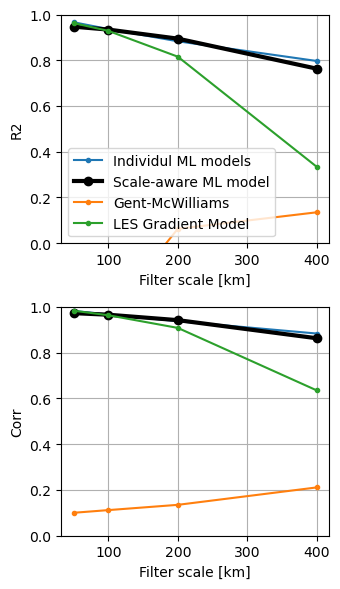

In [26]:
plt.figure(figsize= (3.5, 6))
plt.subplot(211)
plt.plot(Lscale, 0.5*(R2_all_y+R2_all_x),'.-', label='Individul ML models')
#plt.plot(Lscale, 0.5*(R2_all_y_all+R2_all_x_all),'.-', label='One model for all res')
plt.plot(Lscale, (R2_y_ML),'o-', label='Scale-aware ML model', linewidth=3., color='k')
plt.plot(Lscale, (R2_y_GM),'.-', label='Gent-McWilliams')
plt.plot(Lscale, (R2_y_VGM),'.-', label='LES Gradient Model')

plt.xlabel('Filter scale [km]')
plt.ylabel('R2')
plt.ylim([0., 1.])
plt.legend(loc='lower left')
#plt.title('First order models')
plt.grid()

plt.subplot(212)
plt.plot(Lscale, 0.5*(corr_all_x+corr_all_y),'.-', label='Trained on individual res')
#plt.plot(Lscale, 0.5*(corr_all_x_all+corr_all_y_all),'.-', label='One model for all res')
plt.plot(Lscale, (corr_y_ML),'o-', label='All res', linewidth=3., color='k')
plt.plot(Lscale, (corr_y_GM),'.-', label='GM')
plt.plot(Lscale, (corr_y_VGM),'.-', label='VGM')
plt.xlabel('Filter scale [km]')
plt.ylabel('Corr')
plt.ylim([0., 1.])
#plt.legend()
#plt.title('First order models')
plt.grid()

plt.tight_layout()

plt.savefig('comparison_models.png', dpi=300)

In [63]:
R2_all_y_mix = np.zeros((4,5))
R2_all_x_mix = np.zeros((4,5))

corr_all_y_mix = np.zeros((4,5))
corr_all_x_mix = np.zeros((4,5))

Lscale1 = np.zeros((4,))
Lscale2 = np.zeros((4,))

for i, L in enumerate(Lkey):
    for j, L2 in enumerate(Lkey_copy):
        ds = ds_pred_tree_mix[L+'-'+L2]
        
        true = ds['Sfny_true'].isel(time=slice(-30, -1)).sel(YC=slice(400e3, 1600e3), Z=slice(-200, -2000))
        pred = ds['Sfny_pred'].isel(time=slice(-30, -1)).sel(YC=slice(400e3, 1600e3), Z=slice(-200, -2000))

        R2_all_y_mix[i, j] =  R2_score(true, pred, ['XC', 'YC', 'time','Z']).values
        corr_all_y_mix[i, j] = corr(true, pred).values
        
        true = ds['Sfnx_true'].isel(time=slice(-30, -1)).sel(YC=slice(400e3, 1600e3), Z=slice(-200, -2000))
        pred = ds['Sfnx_pred'].isel(time=slice(-30, -1)).sel(YC=slice(400e3, 1600e3), Z=slice(-200, -2000))

        R2_all_x_mix[i, j] =  R2_score(true, pred, ['XC', 'YC', 'time','Z']).values
        corr_all_x_mix[i, j] = corr(true, pred).values
        
    Lscale1[i] = int(L)

In [64]:
R2_all_y_mix

array([[ 9.71193252e-01, -7.05428410e+00, -8.68656921e+01,
        -2.53807190e+02,  9.65004699e-01],
       [ 3.97013485e-01,  9.44843527e-01, -5.40338326e+00,
        -3.13145180e+01,  9.41199229e-01],
       [ 8.29082727e-02,  3.36015642e-01,  8.94285142e-01,
        -2.05136514e+00,  8.97263973e-01],
       [ 8.47685337e-03,  4.37977910e-02,  1.90070212e-01,
         7.82403901e-01,  7.87694860e-01]])

In [65]:
corr_all_y_mix

array([[0.98539126, 0.97214532, 0.89451951, 0.73544061, 0.98235148],
       [0.96729672, 0.97176319, 0.93211961, 0.78972864, 0.96977249],
       [0.90579057, 0.92102981, 0.94287539, 0.87009889, 0.94422792],
       [0.60880089, 0.56380612, 0.7385149 , 0.87064904, 0.87702737]])

In [71]:
Lscale1

array([ 50., 100., 200., 400.])

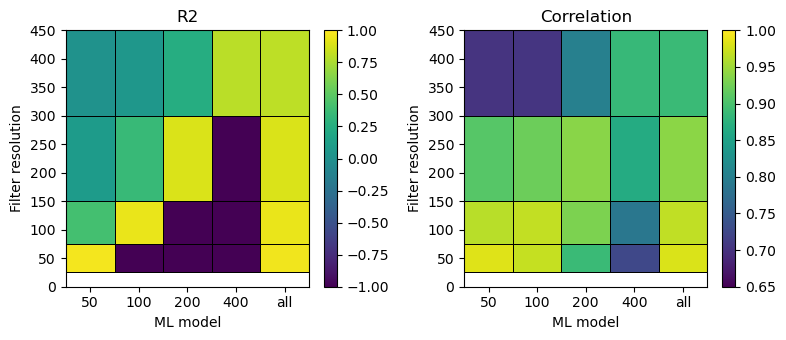

In [84]:
plt.figure(figsize= (8, 3.5))


plt.subplot(121)
plt.pcolormesh(np.arange(0, 5), Lscale1, 0.5*(R2_all_y_mix + R2_all_x_mix), vmin=-1, vmax=1, edgecolor='k', linewidth=.6)
plt.xticks(np.arange(0, 5), Lkey_copy)
plt.xlabel('ML model')
plt.ylabel('Filter resolution')
plt.title('R2')
plt.colorbar()
plt.ylim([0, 450])

plt.subplot(122)
plt.pcolormesh(np.arange(0, 5), Lscale1, 0.5*(corr_all_y_mix + corr_all_x_mix), vmin=0.65, vmax=1, edgecolor='k', linewidth=.6)
plt.xticks(np.arange(0, 5), Lkey_copy)
plt.xlabel('ML model')
plt.ylabel('Filter resolution')
plt.title('Correlation')
plt.colorbar()
plt.ylim([0, 450])

plt.tight_layout()